# Milestone Project 2: SkimLit 📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the data set we'll be using is avaiable here https://arxiv.org/abs/1710.06071)

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

## Confirm access to a GPU

In [144]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-16d3f99b-4181-348a-cbed-4e971613df93)


## Get data

Since we'll be replicating the paper above (PubMed 200K RCT), let's download the dataset they used.

We can do so from the authors GitHub. https://github.com/Franck-Dernoncourt/pubmed-rct

In [145]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [146]:
# Check wat files are in the PubMed_20K_dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [147]:
# Start our experiments using the 20K dataset with numbers replaced by "@" 
data_dir  = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [148]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, visualize, visualize

So with that in mind let's write a function to read in all of the lines of a target text file.

In [149]:
# Create a function to read the lines of a document

def get_lines(filename):
    '''
    Reads filename (a text filename) and returns the lines of text as a list.

    Args:
        filename: a string contianing the target filepath

    Returns:
        A list of strings with one string per line from the target filename.
    '''
    with open(filename, 'r') as f:
        return f.readlines()

In [150]:
# Let's read in the training lines
train_lines = get_lines(data_dir+'train.txt') # read the lines within the training file

Let's think about how we wnat our data to look...

How I think our data would be best represented... 

```
[{'line_number': 0,
    'target':  'BACKGROUND',
    'text':  <TEXT>,
    'total_lines': 11},
    ...]
```

In [151]:
def preprocess_text_with_line_numbers(filename):
    '''
    Returns a list of dictonaries of abstact line data.

    Takes in filename, read it contents and sorts through each line,
    extracting things like the target label, the text of senteces,
    how many sentences are in the current abstract and what sentence number the target
    is
    '''
    input_lines = get_lines(filename) #get all lines from filename
    abstract_lines = '' #create an empty abstract
    abstract_samples = [] # create an empty list of abstracts

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith('###'): #check to see if the string is an ID line
            abstract_id = line
            abstract_lines = '' # reset the abstract string if the line is an ID line

        elif line.isspace(): # check to se if line is a new line
            abstract_line_split = abstract_lines.splitlines() # split abstract into separte lines

            # iterate them through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create emtpy dict for each line
                target_text_split = abstract_line.split('\t') #split target label from text
                
                line_data['target'] = target_text_split[0] # get target label
                line_data['text'] = target_text_split[1].lower() # get target text and lower it
                line_data['line_number'] = abstract_line_number #what number line does the line appear in our abstract
                line_data['total_lines'] = len(abstract_line_split)-1 # How many total lines are in the target abstract (start from 0)
                abstract_samples.append(line_data) # add line data to abstract samples list

        else: # if the above conditions aren't fullfilled, the line contains a labelled sentece
            abstract_lines += line
    return abstract_samples

In [152]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+'/train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'/dev.txt') #dev is another way to call it
test_samples = preprocess_text_with_line_numbers(data_dir+'/test.txt') 
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 609 ms, sys: 101 ms, total: 710 ms
Wall time: 818 ms


In [153]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is the format of a list of dictonaries, how about we run it inot a DataFrame to further visualize it

In [154]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [155]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

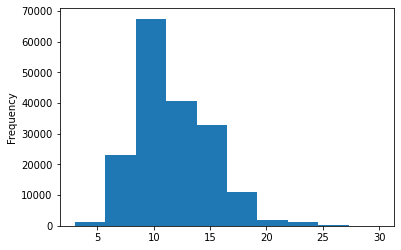

In [156]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentences

In [157]:
# Convert abstract text lines into lists

train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [158]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels (ML models requiere numeric labels)

In [159]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False) # We want a non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform((val_df['target']).to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform((test_df['target']).to_numpy().reshape(-1, 1))

# Check what one got encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [160]:
# Extract labels ('target' columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [161]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive BAyes classifier).

## Model 0: Getting a baseline 

In [162]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline

model_0 = Pipeline([
                    ('tf-idf', TfidfVectorizer()),
                    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data

model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [163]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [164]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script
In the previous module we wrote a function to compare predictions across different metrics (accuracy, preicison, recall and f1) and rather than rewriting here, let's download it from  our helper functions git

In [165]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-23 20:34:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-23 20:34:37 (66.3 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [166]:
from helper_functions import calculate_results

In [167]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (the text) for deep sequence models

Before we start bulding deeper models, we've got to create vectorization an embedding layers

In [168]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [169]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

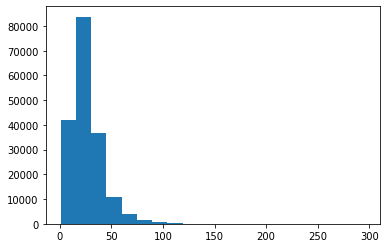

In [170]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 20);

In [171]:
# How long of a sentences lenght covers 95% of examples?
output_seq_len = int(np.quantile(sent_lens, 0.95))
output_seq_len

55

In [172]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our text from words to number

In [173]:
# How many words are in our vocab? (taken from table 2 in paper)
max_tokens = 68000

# Create text vectorizer
text_vectorizer =   layers.TextVectorization(max_tokens= max_tokens, # number of words in vocabulary
                                            output_sequence_length = output_seq_len, # desired output lenght
                                             )

In [174]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [175]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n {target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])}')

Text:
 one - , @ - , and @-year recurrence-free survival rates in patients with small-diameter tumors ( @ cm ) were @ % , @ % , @ % in the adjuvant rt group and @ % , @ % , @ % in the control group ( p = @ , log-rank test ) .

Length of text: 56

Vectorized text: [[   88     3   157  5625   201   162     5    12     7 28475  1563   520
      9     5     2  1071  1095    13     3     5     2    35    13    14
   2344   128     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [176]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [177]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization_1',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Create customtext embedding 

In [178]:
# Create token emebedding
token_embedding = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                   output_dim = 128, # Note different embedding sizes results in drastically different numbers of params
                                   mask_zero = False, # use masking to handle variables sequences lengths(save space)
                                   name = 'token_embedding'
                                   )

In [179]:
# show example embedding
print(f'Sentence before vectorization: \n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization: \n {vectorized_sentence}\n')
embedded_sentence = token_embedding(vectorized_sentence)
print(f'Sentence after embedding: \n {embedded_sentence}\n')
print(f'Embedded sentence shape: \n {embedded_sentence.shape}\n')

Sentence before vectorization: 
 one - , @ - , and @-year recurrence-free survival rates in patients with small-diameter tumors ( @ cm ) were @ % , @ % , @ % in the adjuvant rt group and @ % , @ % , @ % in the control group ( p = @ , log-rank test ) .

Sentence after vectorization: 
 [[   88     3   157  5625   201   162     5    12     7 28475  1563   520
      9     5     2  1071  1095    13     3     5     2    35    13    14
   2344   128     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding: 
 [[[-4.2713083e-02  2.9307868e-02 -4.5707680e-02 ...  9.8652467e-03
    8.3799139e-03  3.9659441e-05]
  [-7.2564930e-04  3.6608949e-03  9.3662143e-03 ... -1.1762906e-02
    2.4684515e-02 -4.0074848e-02]
  [ 3.0673239e-02 -3.9054655e-02  2.2826567e-03 ...  3.1403903e-02
    1.9119803e-02 -1.5569996e-02]
  ...
  [ 2.1868460e-03  2.8887127e-02  1

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the Tensorflow tf.data.API 


In [180]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [181]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1d with token embeddings

In [182]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # Vectorize text inputs
token_embed = token_embedding(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embed)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_1.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
________________________________________________

In [183]:
# Fit the model
history_model_1  = model_1.fit(train_dataset,
                               epochs = 3,
                               steps_per_epoch = int(0.1*len(train_dataset)),
                               validation_data = valid_dataset,
                               validation_steps = int(0.1*len(valid_dataset)) # only validate on 10% of batches
                               )

Epoch 1/3
562/562 [==============================] - 9s 14ms/step - loss: 0.9220 - accuracy: 0.6349 - val_loss: 0.6880 - val_accuracy: 0.7397
Epoch 2/3
562/562 [==============================] - 8s 13ms/step - loss: 0.6602 - accuracy: 0.7549 - val_loss: 0.6334 - val_accuracy: 0.7683
Epoch 3/3
562/562 [==============================] - 8s 13ms/step - loss: 0.6172 - accuracy: 0.7759 - val_loss: 0.5958 - val_accuracy: 0.7866


In [184]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.5982 - accuracy: 0.7877


[0.5982362627983093, 0.7877002358436584]

In [185]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.3709251e-01, 1.7100148e-01, 7.7980831e-02, 2.8020591e-01,
         3.3719238e-02],
        [4.3928388e-01, 2.8171751e-01, 1.1083541e-02, 2.6015538e-01,
         7.7596791e-03],
        [1.4356667e-01, 9.7654611e-03, 1.5928030e-03, 8.4504163e-01,
         3.3410262e-05],
        ...,
        [2.7913748e-06, 5.7781761e-04, 5.0699658e-04, 1.6086499e-06,
         9.9891078e-01],
        [7.7228948e-02, 4.9180070e-01, 1.0489479e-01, 8.4187187e-02,
         2.4188839e-01],
        [1.5922531e-01, 6.4851558e-01, 4.6517212e-02, 6.0235281e-02,
         8.5506633e-02]], dtype=float32), (30212, 5))

In [186]:
# convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [187]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.77002515556732,
 'f1': 0.7856109987124553,
 'precision': 0.7847136781920611,
 'recall': 0.7877002515556732}

In [188]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 2 : Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow Hub more specifically from Universal sentence encoder 

The paper originally used GloVe embeddings, however we're going to stick with the later created USE word embedding.

In [189]:
# Download pretrained Tensorflow Hub USE
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name = 'universal_sentence_encoder')

In [190]:
# Test out pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random sentences:\n {random_train_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding: \n{use_embedded_sentence[0][:13]}\n')
print(f'Length of sentence embedding: \n{len(use_embedded_sentence[0])}\n')

Random sentences:
 physical inactivity and a poor diet predict lifestyle diseases such as diabetes , cardiovascular disease , and certain types of cancer .
Sentence after embedding: 
[-0.0035939  -0.07388819  0.03568345  0.00637029 -0.00691944 -0.08111174
 -0.00930521 -0.04855522 -0.00727471  0.0151181   0.08283895 -0.06399973
 -0.01266567]

Length of sentence embedding: 
512



### Building and fitting an NLP feature extraction model using pretrained embeddings Tensorflow Hub

In [191]:
# Define feature extraction model using TF Hub layer

inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation='softmax')(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name='model_2_USE_feature_extractor')

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Summary
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_20 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [192]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset, 
                              epochs = 3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 20ms/step - loss: 0.9196 - accuracy: 0.6480 - val_loss: 0.7997 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7697 - accuracy: 0.7022 - val_loss: 0.7558 - val_accuracy: 0.7055
Epoch 3/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7518 - accuracy: 0.7123 - val_loss: 0.7378 - val_accuracy: 0.7148


In [193]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.7395 - accuracy: 0.7149


[0.7395291924476624, 0.7149146199226379]

In [194]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.1664100e-01, 4.0561980e-01, 2.7257951e-03, 1.6714483e-01,
        7.8686010e-03],
       [3.1754318e-01, 5.3422856e-01, 4.5676515e-03, 1.4116560e-01,
        2.4950495e-03],
       [2.3996533e-01, 1.4936157e-01, 1.7799022e-02, 5.5503190e-01,
        3.7842214e-02],
       ...,
       [1.9770295e-03, 5.3613079e-03, 5.3474389e-02, 9.3354867e-04,
        9.3825376e-01],
       [5.3592371e-03, 4.9265854e-02, 2.0580688e-01, 2.1237584e-03,
        7.3744428e-01],
       [1.7568184e-01, 2.7834713e-01, 4.9205405e-01, 6.4923698e-03,
        4.7424689e-02]], dtype=float32)

In [195]:
# Convert the predictions probs with feature extraction model to label
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [196]:
# Calculate results from TF Hub pretrained embeddings on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred= model_2_preds)
model_2_results

{'accuracy': 71.49146034688204,
 'f1': 0.7119899168669048,
 'precision': 0.715180496683668,
 'recall': 0.7149146034688203}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

## Creating a character-level tokenizer

In [197]:
# Make function to split sentences into characters

def split_chars(text):
    return ' '.join(list(text))

# Text splitting non-character level sequence into characters
split_chars(random_train_sentence)

'p h y s i c a l   i n a c t i v i t y   a n d   a   p o o r   d i e t   p r e d i c t   l i f e s t y l e   d i s e a s e s   s u c h   a s   d i a b e t e s   ,   c a r d i o v a s c u l a r   d i s e a s e   ,   a n d   c e r t a i n   t y p e s   o f   c a n c e r   .'

In [198]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [199]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

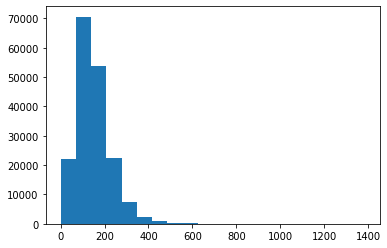

In [200]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=20);

In [201]:
# Find what characte length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [202]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [203]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2  # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = layers.TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                            output_sequence_length = output_seq_char_len,
                                           # standarize = None, # set standarization to 'None' if you want to leave puntuaction in
                                            name = 'char_vectorizer')

In [204]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [205]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [206]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n {random_train_chars}')
print(f'\nLength of random_train_chars: {len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized chars:\n {vectorized_chars}')
print(f'\nLenght of vectorized chars:\n {len(vectorized_chars[0])}')

Charified text:
 a   c o l l a g e n   s c a f f o l d   s e e d e d   w i t h   b o n e   m a r r o w - d e r i v e d   c e l l s   (   b m d c s   )   h a r v e s t e d   f r o m   p a t i e n t   ' s   i l i a c   c r e s t   a n d   i m p l a n t e d   i n t o   t h e   o l t   t h r o u g h   a   s i n g l e   a r t h r o s c o p i c   p r o c e d u r e   h a s   b e e n   r e c e n t l y   p r o p o s e d   a s   a n   e f f e c t i v e   t r e a t m e n t   o p t i o n   .

Length of random_train_chars: 198

Vectorized chars:
 [[ 5 11  7 12 12  5 18  2  6  9 11  5 17 17  7 12 10  9  2  2 10  2 10 20
   4  3 13 22  7  6  2 15  5  8  8  7 20 10  2  8  4 21  2 10 11  2 12 12
   9 22 15 10 11  9 13  5  8 21  2  9  3  2 10 17  8  7 15 14  5  3  4  2
   6  3  9  4 12  4  5 11 11  8  2  9  3  5  6 10  4 15 14 12  5  6  3  2
  10  4  6  3  7  3 13  2  7 12  3  3 13  8  7 16 18 13  5  9  4  6 18 12
   2  5  8  3 13  8  7  9 11  7 14  4 11 14  8  7 11  2 10 16  8  2 13  5
   9 22  2  2  6

## Creating a character-level embedding

In [207]:
# Create character-level embedding
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim = 25, # Size of the char embedding in the paper
                              mask_zero = False, 
                              name = 'character_embedding')

In [208]:
# Test our character embedding layer
print(f'Charified text:\n {random_train_chars}\n')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars (after vectorization and embeddings):\n {char_embed_example}\n')
print(f'Char embedded shape:\n {char_embed_example.shape}')

Charified text:
 a   c o l l a g e n   s c a f f o l d   s e e d e d   w i t h   b o n e   m a r r o w - d e r i v e d   c e l l s   (   b m d c s   )   h a r v e s t e d   f r o m   p a t i e n t   ' s   i l i a c   c r e s t   a n d   i m p l a n t e d   i n t o   t h e   o l t   t h r o u g h   a   s i n g l e   a r t h r o s c o p i c   p r o c e d u r e   h a s   b e e n   r e c e n t l y   p r o p o s e d   a s   a n   e f f e c t i v e   t r e a t m e n t   o p t i o n   .

Embedded chars (after vectorization and embeddings):
 [[[ 0.01268243 -0.04180726  0.03579077 ... -0.00076684  0.04464364
   -0.02837536]
  [ 0.01262366 -0.00865104 -0.02953692 ...  0.0352232  -0.02111273
    0.00848917]
  [ 0.01610004  0.03339801 -0.00797746 ...  0.04060617 -0.03422822
    0.03782426]
  ...
  [-0.03280616  0.00624807 -0.00205072 ...  0.01597066 -0.03308962
   -0.02068337]
  [-0.03280616  0.00624807 -0.00205072 ...  0.01597066 -0.03308962
   -0.02068337]
  [-0.03280616  0.00624807 -0.00205072 

## Building a Conv1D model to fit on character embeddings 

In [209]:
# Building model
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embedding = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=10, padding='same', activation='relu')(char_embedding)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs = inputs, 
                            outputs = outputs,
                            name='model_3_conv1d_char_embedding')

# Compile
model_3.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# summary
model_3.summary()

Model: "model_3_conv1d_char_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
character_embedding (Embeddi (None, 290, 25)           700       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 290, 64)           16064     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 325       
Total params: 17,089
Trainable params: 17,089
Non-trainable params: 0
_________________________________

In [210]:
# Create char level dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [211]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              epochs = 3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 11ms/step - loss: 1.2011 - accuracy: 0.5154 - val_loss: 0.9714 - val_accuracy: 0.6213
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.9370 - accuracy: 0.6293 - val_loss: 0.8607 - val_accuracy: 0.6679
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.8528 - accuracy: 0.6682 - val_loss: 0.7940 - val_accuracy: 0.6925


In [212]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.19824505, 0.47784522, 0.0597427 , 0.23259895, 0.03156818],
       [0.32553062, 0.15416752, 0.04522025, 0.43436208, 0.04071944],
       [0.16627055, 0.11077702, 0.05547777, 0.6222941 , 0.0451806 ],
       ...,
       [0.00952424, 0.03648717, 0.04768376, 0.01412871, 0.89217615],
       [0.08239434, 0.19941017, 0.3602322 , 0.06095233, 0.29701096],
       [0.4367237 , 0.2544566 , 0.21192513, 0.0797762 , 0.01711836]],
      dtype=float32)

In [213]:
# Convert prediction probs to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 2, 0])>

In [214]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 68.8865351515954,
 'f1': 0.6787011810222826,
 'precision': 0.6804839954172375,
 'recall': 0.688865351515954}

## Model 4: Combining pretrained token embedding + characters embedding (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 and 2 with a concatenate (`layers.Concatenate`)
4. Build a series of layers of output layers on top of 3 similar to Figure 1 and Section 4.2 of the paper.
5. Contruct a model which takes token and character-level sequences as input and produces sequence label prob as output.


In [215]:
# 1. Setup token inputs/model 
token_inputs = layers.Input(shape=[], dtype='string', name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, 
                             outputs = token_outputs,
                             name = 'token_model')

# 2. Setup char inputs / model
char_inputs = layers.Input(shape=(1, ), dtype = tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedding) #bi-LSTM shown in Figure 1 of paper
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm,
                            name = 'char_model')

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2
combined_droput = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_droput)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = 'model_4_token_and_char_embedding')


In [216]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embedding"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
___________________________________________________________________

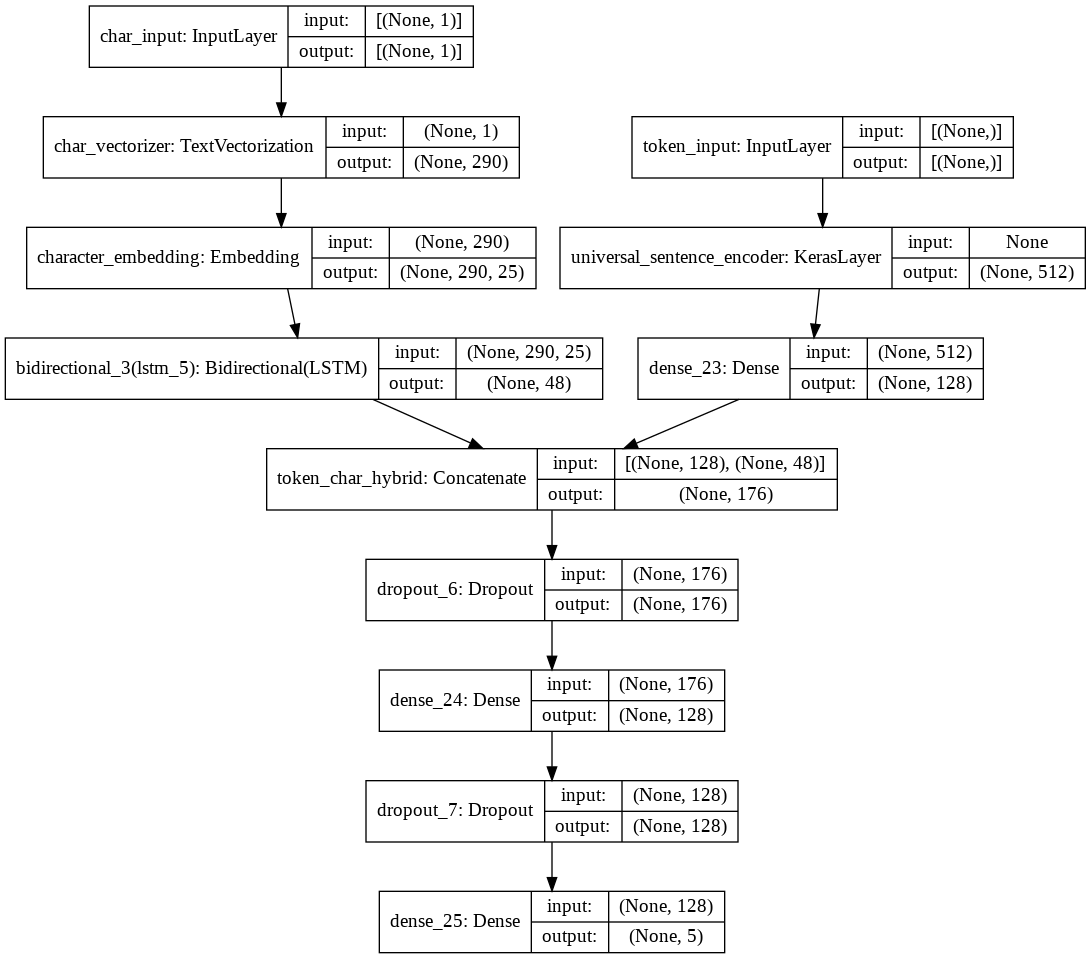

In [217]:
# Plot hybrid token and char model
tf.keras.utils.plot_model(model_4, show_shapes=True)

In [218]:
# Compile token char model
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),# section 4.2 of the paper says they use SGD
                metrics = ['accuracy']) 

### Combining token and character data into a tf.data.Dataset

In [219]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # Make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot)) # Make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # Combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [220]:
# Repeat above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # Make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot)) # Make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # Combine data and labels

# Prefetch and batch val data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [221]:
# Checkout out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

📝 Order matters and it has to be as same as the order of the model above

In [222]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1*len(val_char_token_dataset)),
                              epochs = 3)

Epoch 1/3
562/562 [==============================] - 72s 120ms/step - loss: 0.9868 - accuracy: 0.6038 - val_loss: 0.7739 - val_accuracy: 0.6965
Epoch 2/3
562/562 [==============================] - 66s 118ms/step - loss: 0.8025 - accuracy: 0.6909 - val_loss: 0.7168 - val_accuracy: 0.7281
Epoch 3/3
562/562 [==============================] - 66s 118ms/step - loss: 0.7752 - accuracy: 0.7034 - val_loss: 0.6968 - val_accuracy: 0.7360


In [223]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 50s 53ms/step - loss: 0.7012 - accuracy: 0.7327


[0.7011918425559998, 0.7327221035957336]

In [224]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[3.6288568e-01, 4.2474899e-01, 6.4203660e-03, 1.9586936e-01,
        1.0075711e-02],
       [3.4635952e-01, 4.8089746e-01, 3.9045077e-03, 1.6696620e-01,
        1.8723039e-03],
       [2.5272748e-01, 1.1965542e-01, 5.3727008e-02, 5.3611797e-01,
        3.7772074e-02],
       ...,
       [7.2328100e-04, 8.7963920e-03, 5.4042902e-02, 2.8143567e-04,
        9.3615597e-01],
       [1.0116885e-02, 6.8159096e-02, 2.3206668e-01, 4.3778047e-03,
        6.8527949e-01],
       [3.0138245e-01, 2.8522485e-01, 3.1444520e-01, 4.1560080e-02,
        5.7387374e-02]], dtype=float32)

In [225]:
# Format pred probs into pred labels 
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 2])>

In [226]:
# Get results of token-char hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 73.27220971799285,
 'f1': 0.7300099636931218,
 'precision': 0.7335711192403921,
 'recall': 0.7327220971799285}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embedding

In [227]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> 🔑 **Note:** Any engineered features used to train a model need to be avaiable at test time. In our case line numbers and total lines are available.

### Create positional embeddings 

In [228]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

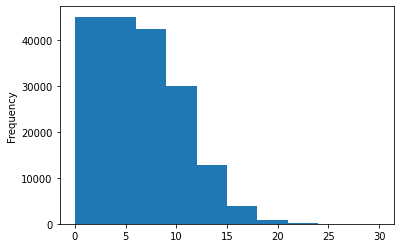

In [229]:
# check the distribution of "line_number" column 
train_df.line_number.plot.hist()

In [230]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

Now we've encoded our lines feature, let's do the same for our total lines feature..

In [231]:
# How many different total lines?
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

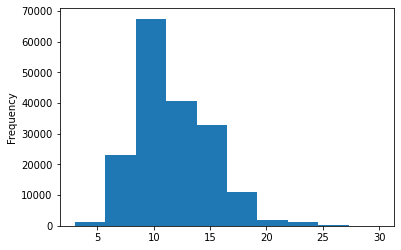

In [232]:
# check the distribution of "total_lines" column 
train_df.total_lines.plot.hist()

In [233]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [234]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'], depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'], depth=20)
tesst_total_lines_one_hot = tf.one_hot(test_df['total_lines'], depth=20)
train_total_lines_one_hot[:5], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>, TensorShape([180040, 20]))

### Building a tribrid embedding model

1. Create a token-level model
2. Create a char level model
3. Create a model for the 'line_number' feature
4. Create a model for the 'total_lines' feature
5. Combine the outputs of 1 and 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4 and 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribried embedding and output label probabilities
8. Combine the inputs of 1, 2 , 3 and 4 and the outputs of 7 into a tf.keras.Model

In [235]:
# 1. Token inputs
token_inputs = layers.Input(shape = [], dtype='string', name ='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape = (1, ), dtype='string', name = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24), name='bilstm')(char_embedding)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape = (15, ), dtype=tf.float32, name = 'line_number_input')
line_number_dense = layers.Dense(32, activation='relu', name='dense_lines')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = line_number_dense)

# 4. Total lines
total_lines_inputs = layers.Input(shape = (20, ), dtype='float', name = 'total_lines_input')
total_lines_dense = layers.Dense(32, activation='relu', name='dense_total_lines')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                   outputs = total_lines_dense)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation='relu', name='combined_embeddings')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name = 'char_token_positional_embedding')([line_number_model.output, # For models you take the output
                                                                                   total_lines_model.output,
                                                                                   z]) # For layer you already took the output

# 7. Create output layer
output_layer = layers.Dense(5, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs = [line_number_model.input, # Order according to the concat
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer)

In [236]:
# Summary
model_5.summary()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
___________________________________________________________________________________________

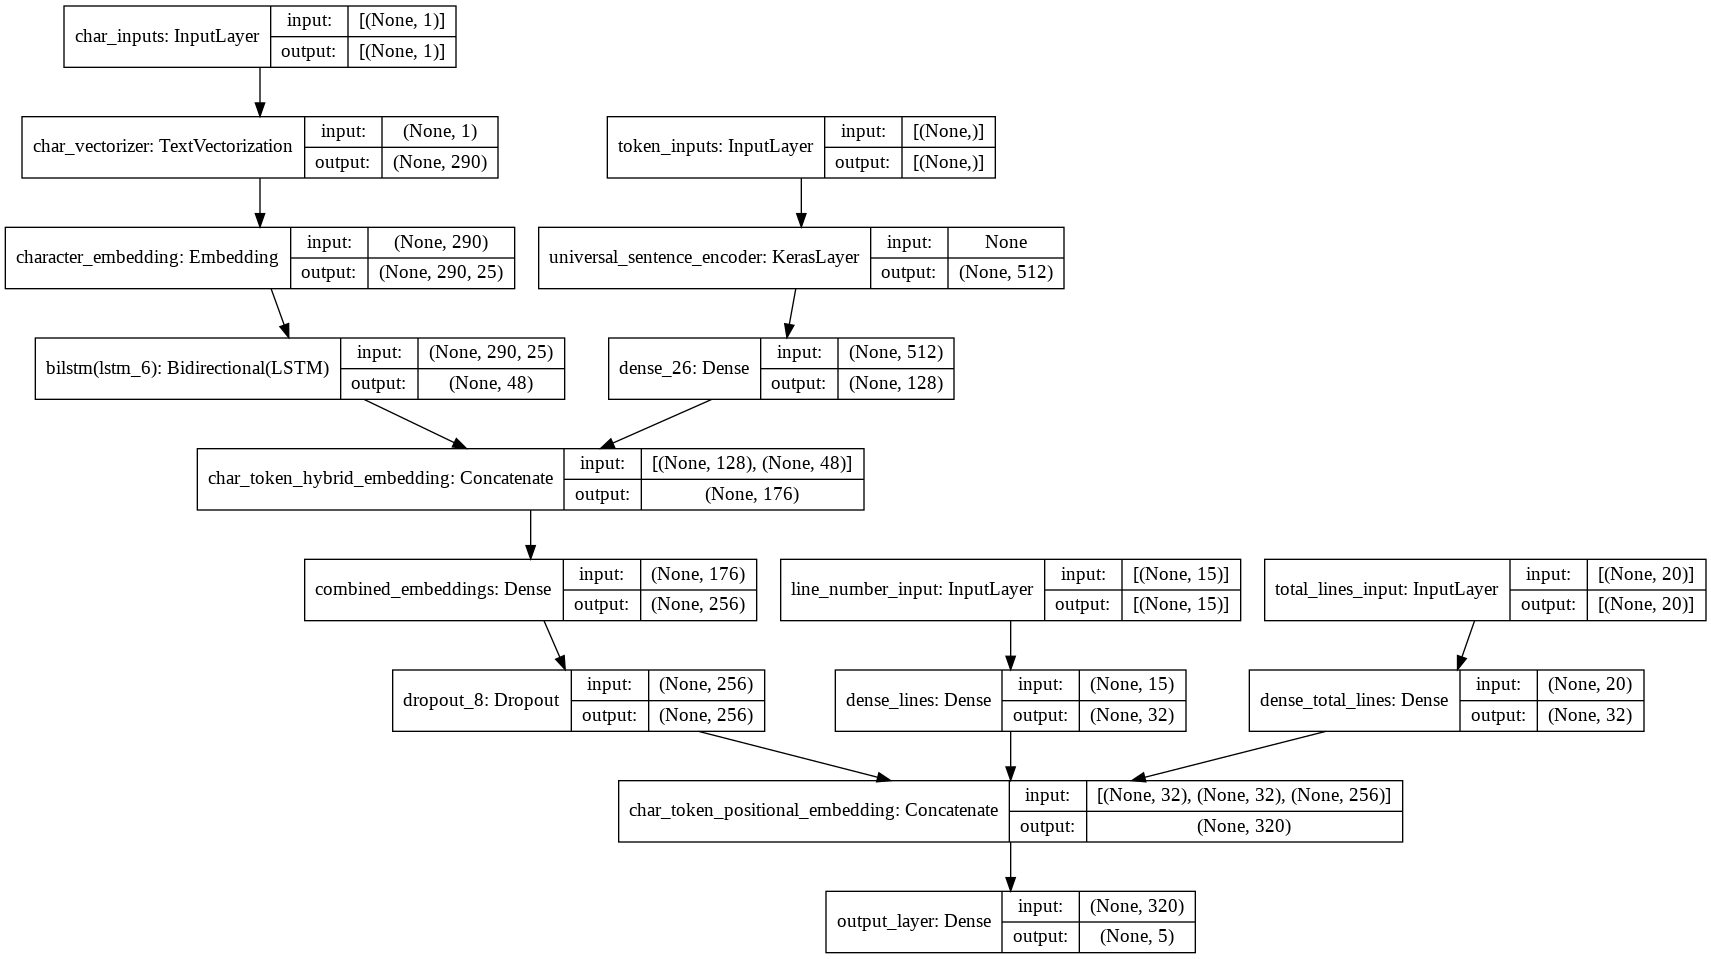

In [237]:
# Plot model_5 to explor it visually
tf.keras.utils.plot_model(model_5, show_shapes=True)

What is label smoothing?

For example if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other clasess...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the values of th highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

> 📖 **Resource:** For more on label smoothing, see this blog post from PyImageSearch: https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [238]:
# compile token, char and positional embedding model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

### Creating tribrid embedding datasets using tf.data

In [239]:
# Combine line, total lines, chars and tokens into a dataset
train_char_token_pos = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # Order as model
                                                  train_total_lines_one_hot,
                                                  train_sentences,
                                                  train_chars)) # Make data
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot)) # Make labels
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos, train_char_token_labels)) # Combine data and labels
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation
val_char_token_pos = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, # Order as model
                                                  val_total_lines_one_hot,
                                                  val_sentences,
                                                  val_chars)) # Make data
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot)) # Make labels
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos, val_char_token_labels)) # Combine data and labels
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [240]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

### Fitting, evaluating and making predictions with our tribid model

In [241]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 72s 120ms/step - loss: 1.0978 - accuracy: 0.7243 - val_loss: 0.9838 - val_accuracy: 0.8015
Epoch 2/3
562/562 [==============================] - 67s 119ms/step - loss: 0.9664 - accuracy: 0.8149 - val_loss: 0.9498 - val_accuracy: 0.8261
Epoch 3/3
562/562 [==============================] - 67s 119ms/step - loss: 0.9510 - accuracy: 0.8228 - val_loss: 0.9381 - val_accuracy: 0.8348


In [242]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose = 1)
model_5_pred_probs

945/945 [==============================] - 52s 51ms/step


array([[0.4983686 , 0.09119782, 0.01335137, 0.3776422 , 0.01944005],
       [0.54916805, 0.0896777 , 0.0516488 , 0.29696903, 0.01253638],
       [0.27952412, 0.08264296, 0.12659405, 0.43223506, 0.07900372],
       ...,
       [0.0361574 , 0.09815208, 0.04062245, 0.03368025, 0.7913878 ],
       [0.03392944, 0.2962128 , 0.08753036, 0.02783924, 0.5544882 ],
       [0.25649172, 0.5880318 , 0.07777806, 0.03687425, 0.04082419]],
      dtype=float32)

In [243]:
# Conver pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [244]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 83.45359459817291,
 'f1': 0.8334030350704446,
 'precision': 0.8336604470731197,
 'recall': 0.8345359459817291}

## Compare model results

In [245]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({'model_0_baseline': baseline_results,
                                  'model_1_custom_token_embedding': model_1_results,
                                  'model_2_pretrained_token_embedding': model_2_results,
                                  'model_3_custom_char_embedding': model_3_results,
                                  'model_4_hybrid_char_token_embedding': model_4_results,
                                  'model_5_pos_char_token_embedding': model_5_results})

all_model_results = all_model_results.T
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.770025,0.784714,0.787700,0.785611
model_2_pretrained_token_embedding,71.491460,0.715180,0.714915,0.711990
model_3_custom_char_embedding,68.886535,0.680484,0.688865,0.678701
model_4_hybrid_char_token_embedding,73.272210,0.733571,0.732722,0.730010
model_5_pos_char_token_embedding,83.453595,0.833660,0.834536,0.833403


In [246]:
# Reduce the acc to same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100

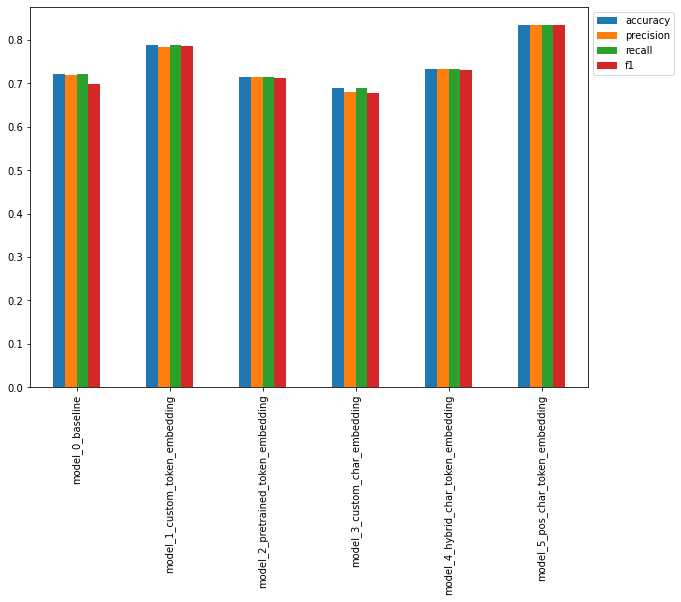

In [247]:
# Plot and compare all model results
all_model_results.plot(kind='bar', figsize = (10, 7)).legend(bbox_to_anchor = (1.0, 1.0));

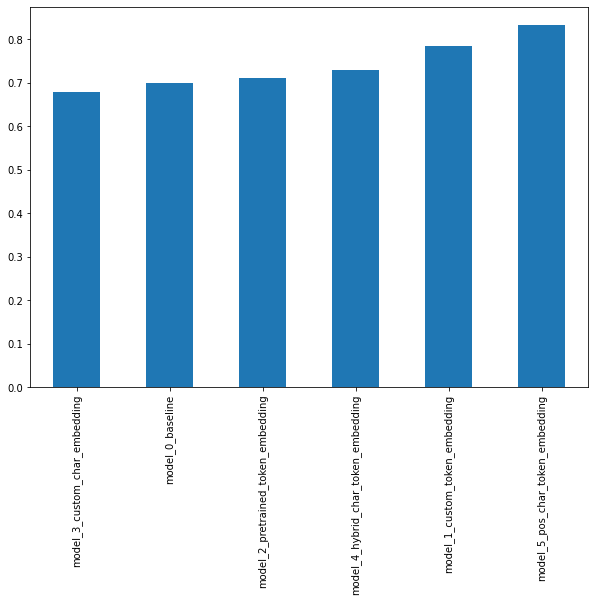

In [248]:
# Sort models results by f1-score
all_model_results.sort_values('f1', ascending=True)['f1'].plot(kind='bar', figsize = (10, 7 ));

## Model 6 : Custom Token Embedding + Char Embedding + Positional Embedding

The custom embedding is a experiment worth to test on our tribid model

In [249]:
# Create token emebedding
token_embedding = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                   output_dim = 128, # Note different embedding sizes results in drastically different numbers of params
                                   mask_zero = False, # use masking to handle variables sequences lengths(save space)
                                   name = 'token_embedding'
                                   )

In [250]:
# 1. Token embedding inputs
token_inputs = layers.Input(shape = (1, ), dtype='string', name ='token_inputs')
text_vectors = text_vectorizer(token_inputs) # Vectorize text inputs
token_embed = token_embedding(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embed)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
token_model = tf.keras.Model(inputs = token_inputs, outputs = x)

# 2. Char inputs
char_inputs = layers.Input(shape = (1, ), dtype='string', name = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24), name='bilstm')(char_embedding)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape = (15, ), dtype=tf.float32, name = 'line_number_input')
line_number_dense = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = line_number_dense)

# 4. Total lines
total_lines_inputs = layers.Input(shape = (20, ), dtype='float', name = 'total_lines_input')
total_lines_dense = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                   outputs = total_lines_dense)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name = 'char_token_positional_embedding')([line_number_model.output, # For models you take the output
                                                                                   total_lines_model.output,
                                                                                   z]) # For layer you already took the output

# 7. Create output layer
output_layer = layers.Dense(5, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_6 = tf.keras.Model(inputs = [line_number_model.input, # Order according to the concat
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer)

In [251]:
# Get Summary
model_6.summary()

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_inputs (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 55)           0           token_inputs[0][0]               
__________________________________________________________________________________________________
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_embedding (Embedding)     (None, 55, 128)      8299648     text_vectorization_1[1][0]       
___________________________________________________________________________________________

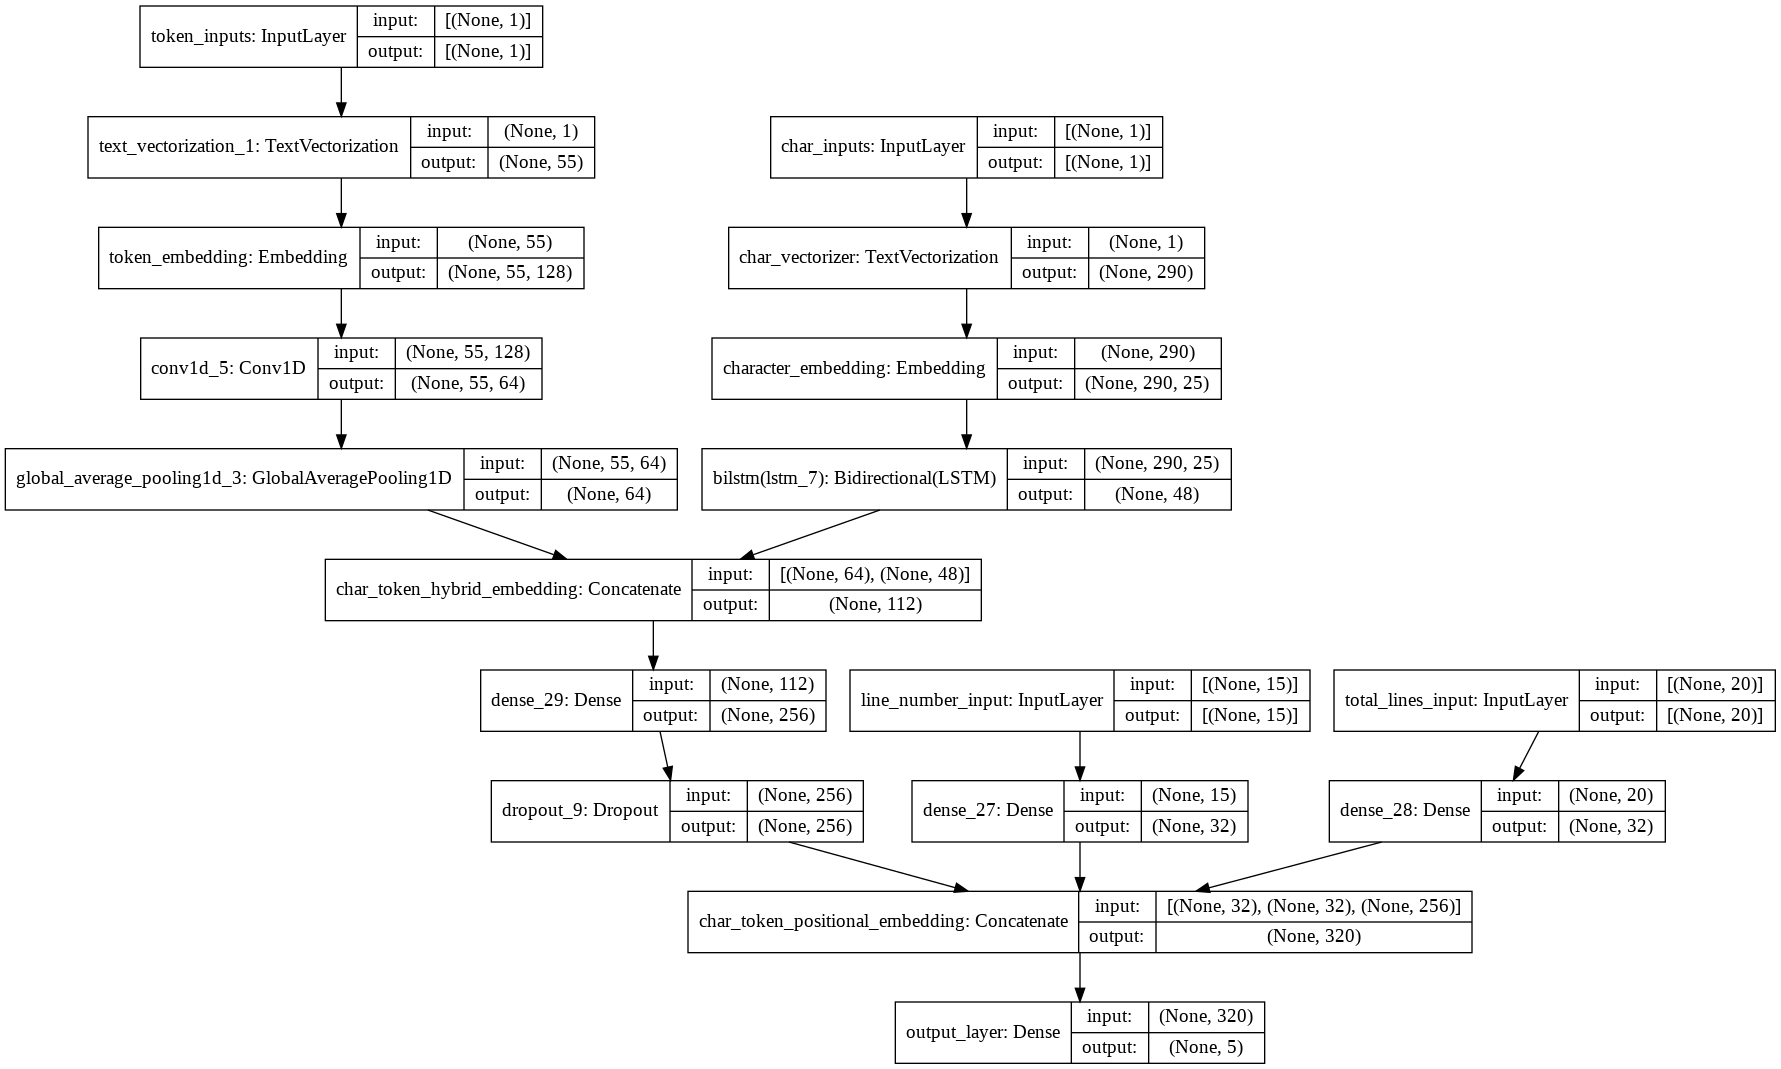

In [252]:
# Plot model_6 to explore it visually
tf.keras.utils.plot_model(model_6, show_shapes=True)

In [253]:
# compile token, char and positional embedding model
model_6.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [254]:
history_model_6 = model_6.fit(train_char_token_pos_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 72s 120ms/step - loss: 1.1095 - accuracy: 0.7094 - val_loss: 0.9511 - val_accuracy: 0.8268
Epoch 2/3
562/562 [==============================] - 67s 119ms/step - loss: 0.9497 - accuracy: 0.8317 - val_loss: 0.9314 - val_accuracy: 0.8348
Epoch 3/3
562/562 [==============================] - 67s 119ms/step - loss: 0.9285 - accuracy: 0.8434 - val_loss: 0.9137 - val_accuracy: 0.8441


In [255]:
# Make predictions with the char token pos model
model_6_pred_probs = model_6.predict(val_char_token_pos_dataset, verbose = 1)
model_6_pred_probs

945/945 [==============================] - 39s 41ms/step


array([[0.43707907, 0.07131559, 0.03670114, 0.42031395, 0.03459018],
       [0.43103683, 0.10766388, 0.06946138, 0.36584195, 0.02599602],
       [0.2519927 , 0.07760977, 0.09664772, 0.5481574 , 0.02559242],
       ...,
       [0.02640562, 0.05650877, 0.02936042, 0.02516961, 0.86255556],
       [0.05113426, 0.64915377, 0.05217572, 0.03557731, 0.21195884],
       [0.08420939, 0.7883436 , 0.04231182, 0.04269993, 0.04243535]],
      dtype=float32)

In [256]:
# Conver pred probs to pred labels
model_6_preds = tf.argmax(model_6_pred_probs, axis = 1)
model_6_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [257]:
# Calculate results of char token pos model
model_6_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_6_preds)
model_6_results

{'accuracy': 85.26082351383556,
 'f1': 0.8514539701644664,
 'precision': 0.8508125492346038,
 'recall': 0.8526082351383556}

In [258]:
model_6_res = pd.DataFrame({'model_6_pos_char_token_cust_embedding':model_6_results}).T
model_6_res['accuracy'] = model_6_res['accuracy']/100
all_model_results = pd.concat([all_model_results, model_6_res], axis = 0)

In [259]:
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.787700,0.784714,0.787700,0.785611
model_2_pretrained_token_embedding,0.714915,0.715180,0.714915,0.711990
model_3_custom_char_embedding,0.688865,0.680484,0.688865,0.678701
model_4_hybrid_char_token_embedding,0.732722,0.733571,0.732722,0.730010
model_5_pos_char_token_embedding,0.834536,0.833660,0.834536,0.833403
model_6_pos_char_token_cust_embedding,0.852608,0.850813,0.852608,0.851454


## Save and Load

In [ ]:
#Save the best performing model to SaveModel format
model_5.save('skimlit_tribid_model_5', save_format='tf', )

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model('skimlit_tribid_model_5')

In [ ]:
# Make predictions
loaded_pred_probs = loaded_model.predict(val_char_pos_token_pos_dataset)
loaded_pred_probs = tf.argmax(loaded_pred_probs, axis = 1)
loaded_pred_probs[:10]

In [ ]:
# Calculate the results
loaded_model_results = calculate_results(y_true = val_labels_encoded,
                                         y_pred = loaded_preds)
loaded_model_results

In [ ]:
assert model_5_results == loaded_model_results